# Demo for Motif Peaks Extraction from RHSNet

This jupyter notbook explains the mechanism of our proposed motif extraction method.

Before running this notebook, pleas make sure that you have the following requirements:

```
tensorflow == 1.12.0
keras = 2.2.4
deeplift

```

To install deeplift, pleas run the following:

```unix
pip install deeplift
```


You should get the ``scores.npy`` file after running the following code (Take HapMap II Dataset as example):

```
python motif_extractor.py experiments/nature_genetics_2008/1000_4/CNN/baseline_classification.json

```

After running the above command, you should get a dir named ``/motifs`` and the following files:


```
└── nature_genetics_2008
    ├── filter0.1
    ├── filter0.1_motifs.json
    ├── filter0.2
    ├── filter0.2_motifs.json
    ├── filter0.4
    ├── filter0.4_motifs.json
    ├── recomb_rate.npy
    └── scores.npy

```


In [1]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
from deeplift.visualization import viz_sequence
from scipy import signal

In [2]:
data = np.load("motifs/nature_genetics_2008/scores.npy")

# Use the first 1000 hotspots as an example
one_hot = np.load("dataset/nature_genetics_2008/1000/X.npy")[0:1000]

## Take one sample input

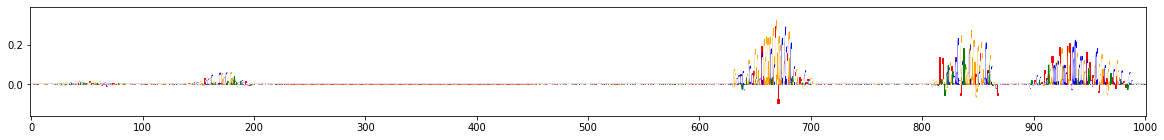

<Figure size 3600x288 with 0 Axes>

In [3]:
sample = data[0]
viz_sequence.plot_weights(sample, subticks_frequency=100)
plt.figure(figsize=(50,4))
plt.show()

In [4]:
sample_non_zero_idx,sample_non_zero_ATCG  = sample.nonzero()
sample_signal = np.zeros((1000,))

for i in range(len(sample_non_zero_idx)):
    pos = sample_non_zero_idx[i]
    sample_signal[pos] = sample[pos][sample_non_zero_ATCG[i]]

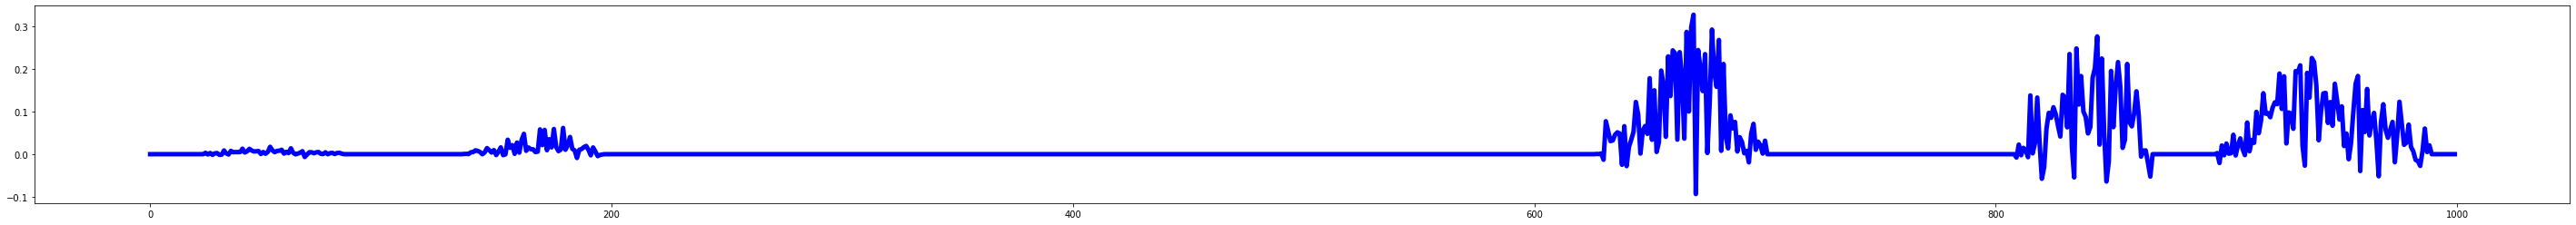

In [5]:
plt.figure(figsize=(50,4))
plt.plot(sample_signal,'b', linewidth=5)
plt.show()

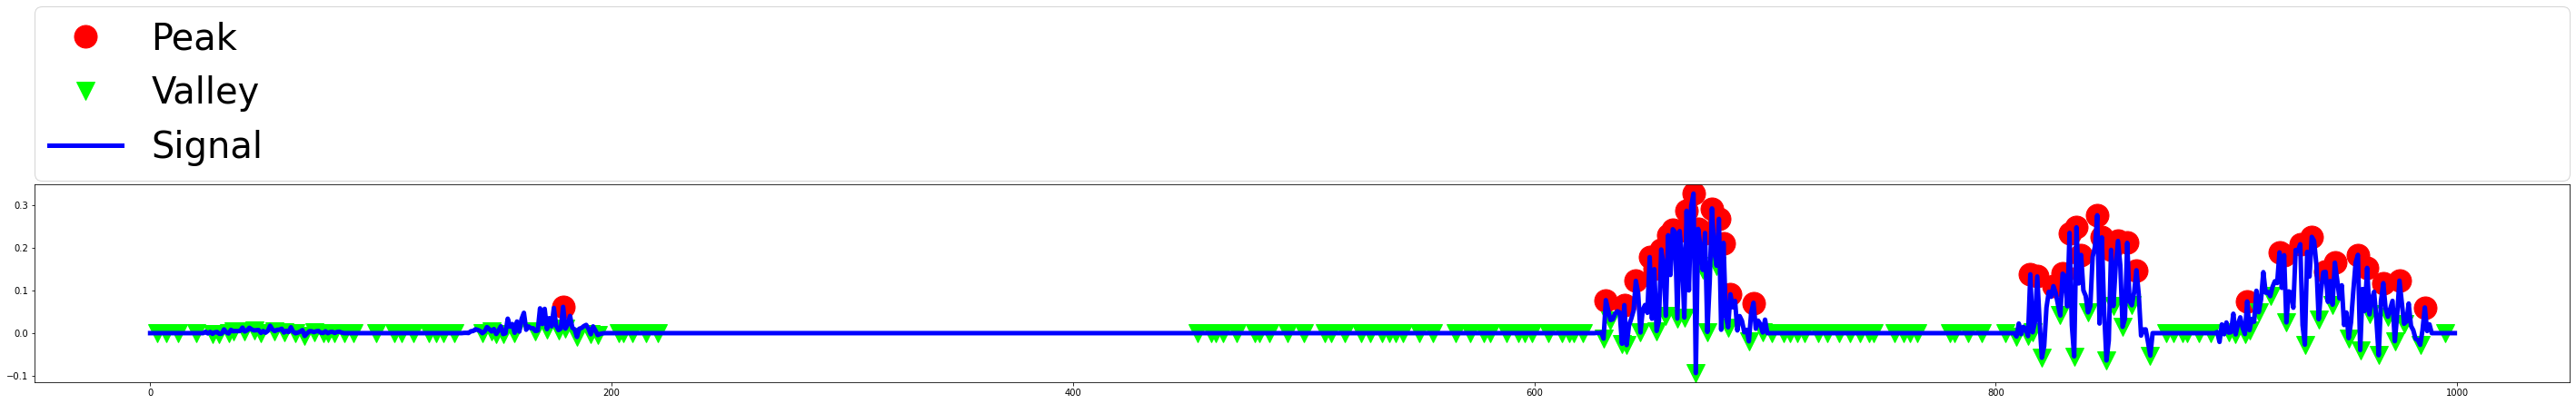

In [6]:
peaks, _ = signal.find_peaks(sample_signal, prominence=0.06)
valleys, _ = signal.find_peaks(sample_signal*(-1), width=1)
plt.figure(figsize=(50,4))

plt.plot(peaks, sample_signal[peaks], color='red', marker='o',markersize=25, linestyle='None')
plt.plot(valleys, sample_signal[valleys], color='lime', marker='v',markersize=20, linestyle='None')
plt.plot(sample_signal,'blue', linewidth=5)

plt.legend(['Peak','Valley','Signal'],fontsize=40,bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                mode="expand", borderaxespad=0,)

plt.show()

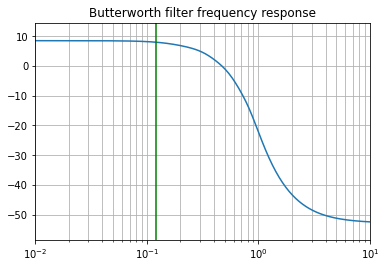

In [7]:
b, a = signal.butter(8, 0.4, 'lowpass') 
w, h = signal.freqs(b, a)
plt.semilogx(w, 20 * np.log10(abs(h)))
plt.title('Butterworth filter frequency response')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.axvline(0.12, color='green',label="cutoff frequency") # cutoff frequency
plt.show()

/home/siyuan/.conda/envs/python36/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


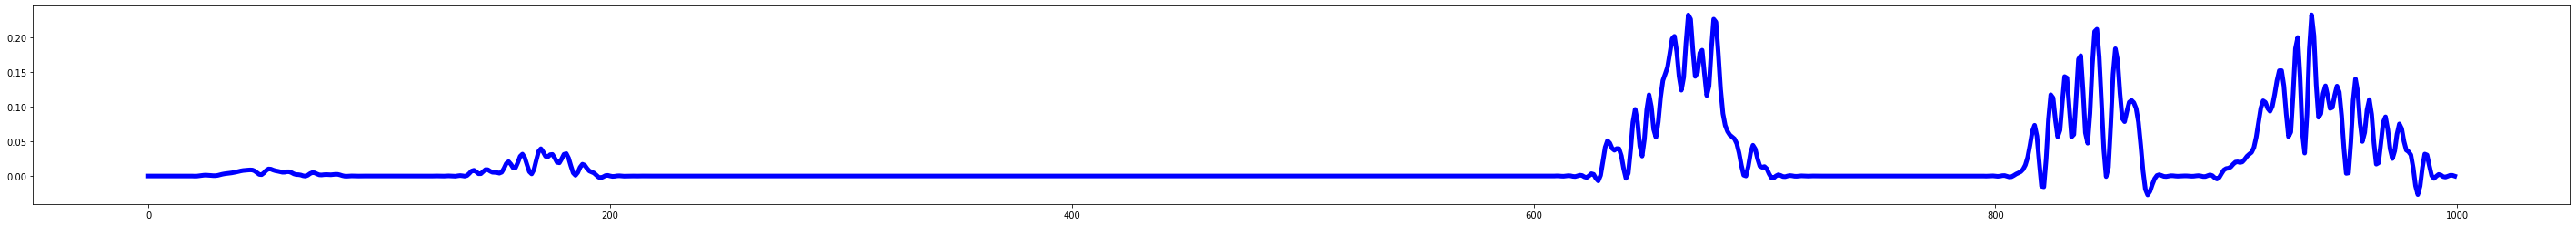

In [8]:
filtered_signal = signal.filtfilt(b, a, sample_signal)  
plt.figure(figsize=(50,4))
plt.plot(filtered_signal ,'b', linewidth=5)
plt.show()

## You can set the factor to be 0.2 lower to have a smooth signal

/home/siyuan/.conda/envs/python36/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


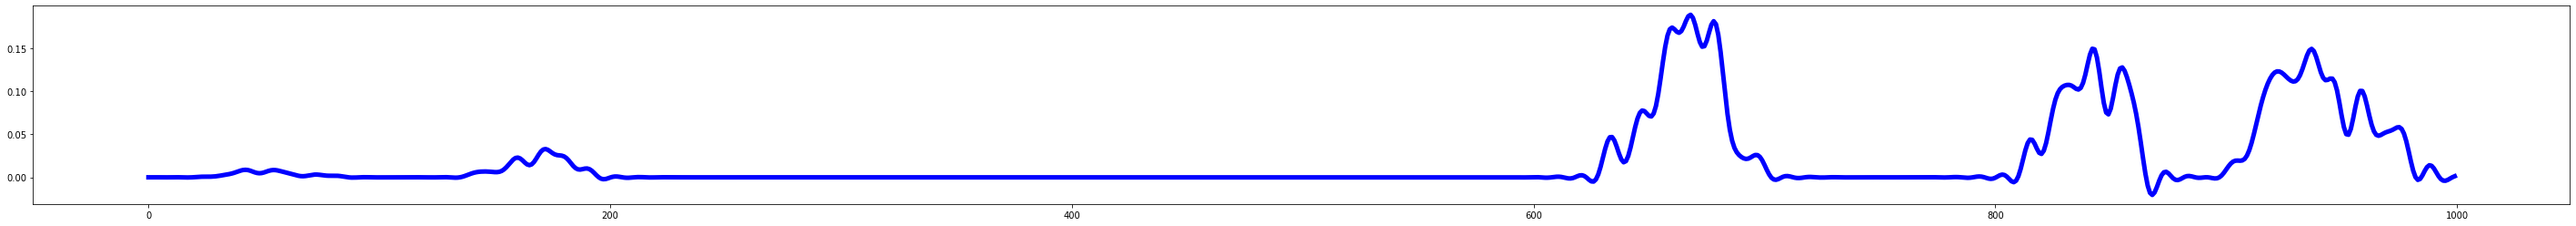

In [9]:
b, a = signal.butter(8, 0.2, 'lowpass') 
filtered_signal = signal.filtfilt(b, a, sample_signal)  
plt.figure(figsize=(50,4))
plt.plot(filtered_signal ,'b', linewidth=5)
plt.show()

# Find Peaks and Valleys

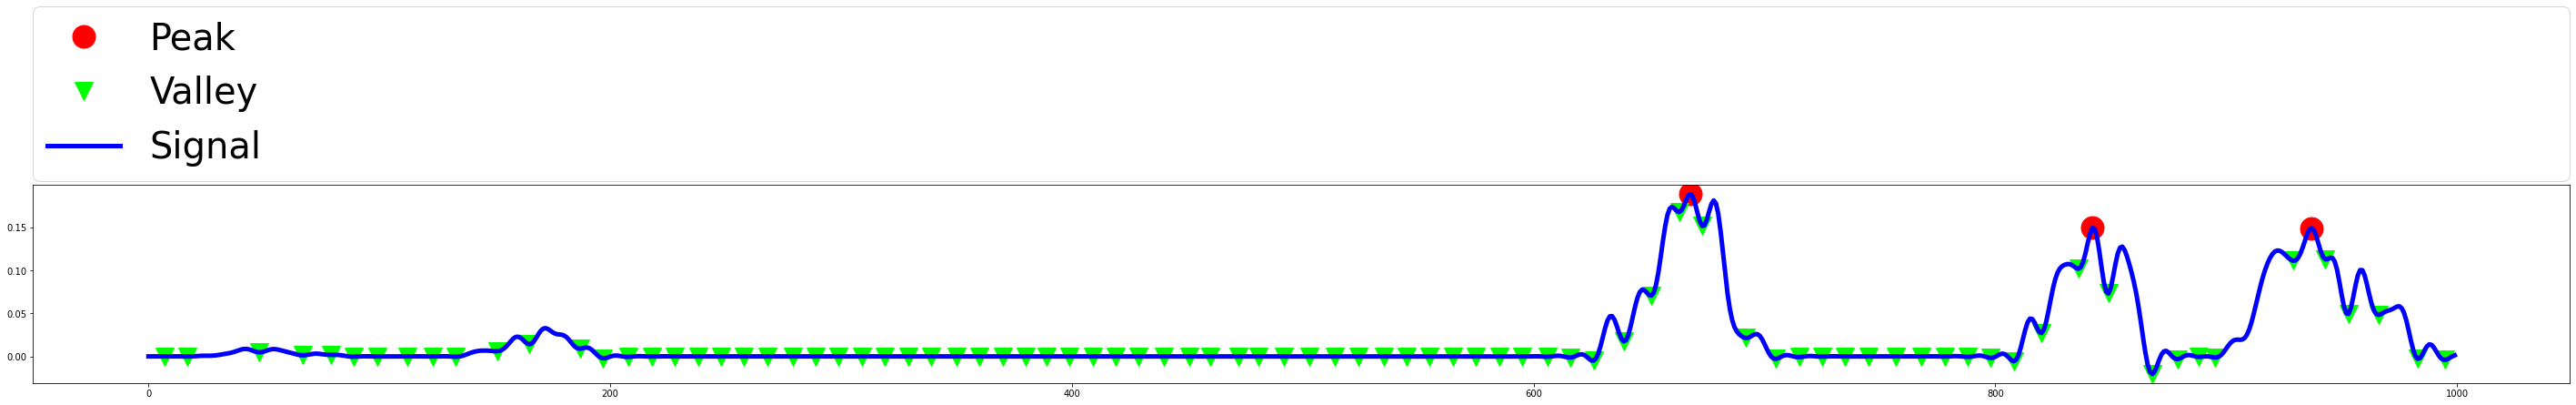

In [10]:

peaks, _ = signal.find_peaks(filtered_signal, prominence=0.06)
valleys, _ = signal.find_peaks(filtered_signal*(-1), width=1)
plt.figure(figsize=(50,4))

plt.plot(peaks, filtered_signal[peaks], color='red', marker='o',markersize=25, linestyle='None')
plt.plot(valleys, filtered_signal[valleys], color='lime', marker='v',markersize=20, linestyle='None')
plt.plot(filtered_signal,'blue', linewidth=5)

plt.legend(['Peak','Valley','Signal'],fontsize=40,bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                mode="expand", borderaxespad=0,)

plt.show()

# Plot the extracted motifs (3 examples)

## Peaks from Filtered Signal

In [11]:
filtered_sample = np.zeros(sample.shape)
for i in range(len(sample_non_zero_idx)):
    pos = sample_non_zero_idx[i]
    filtered_sample[pos,sample_non_zero_ATCG[i]] =  filtered_signal[pos]

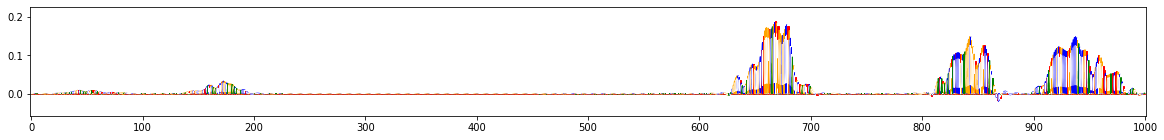

<Figure size 3600x288 with 0 Axes>

In [12]:
viz_sequence.plot_weights(filtered_sample, subticks_frequency=100)
plt.figure(figsize=(50,4))
plt.show()

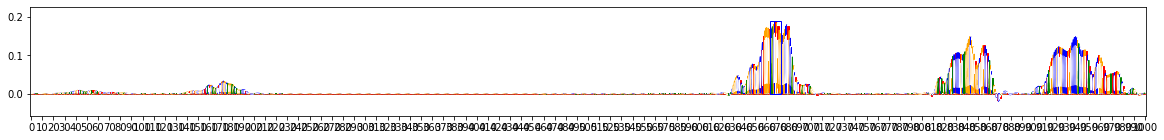

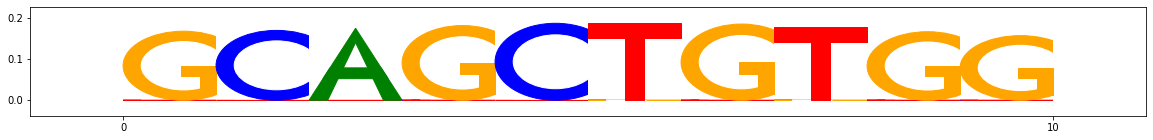

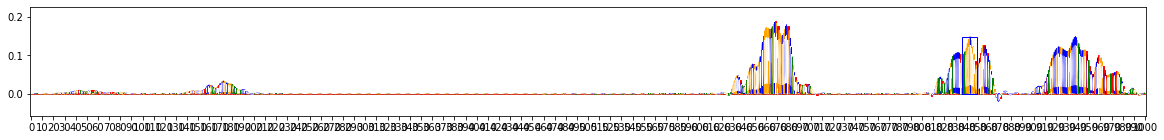

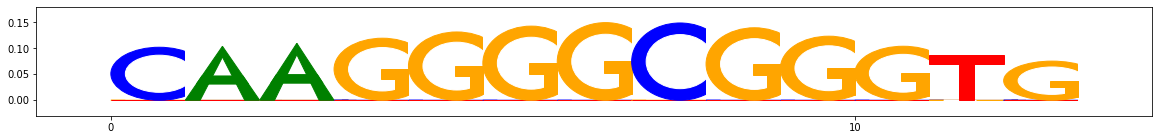

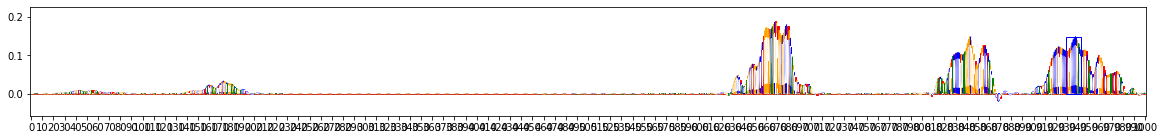

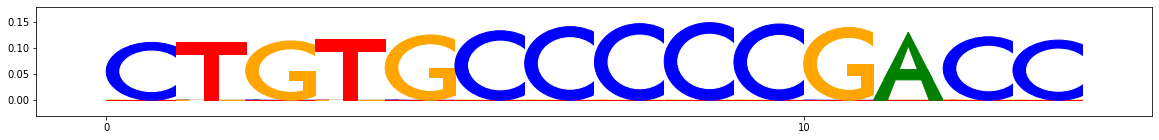

In [13]:
start_idx = []
end_idx = []
for peak in peaks:
    reverse_peak = np.array([valleys[v]-peak for v in range(len(valleys))])
    start = valleys[np.where(reverse_peak < 0, reverse_peak, -np.inf).argmax()]
    end = valleys[np.where(reverse_peak > 0, reverse_peak, np.inf).argmin()]
    start_idx.append(start)
    end_idx.append(end)

for i in range(3):
    highlight_seq = {'blue': [
                (start_idx[i], end_idx[i])]
            }
    viz_sequence.plot_weights(filtered_sample, subticks_frequency=10, highlight=highlight_seq)
    viz_sequence.plot_weights(filtered_sample[start_idx[i]:end_idx[i]], subticks_frequency=10)

## Peaks from original signal

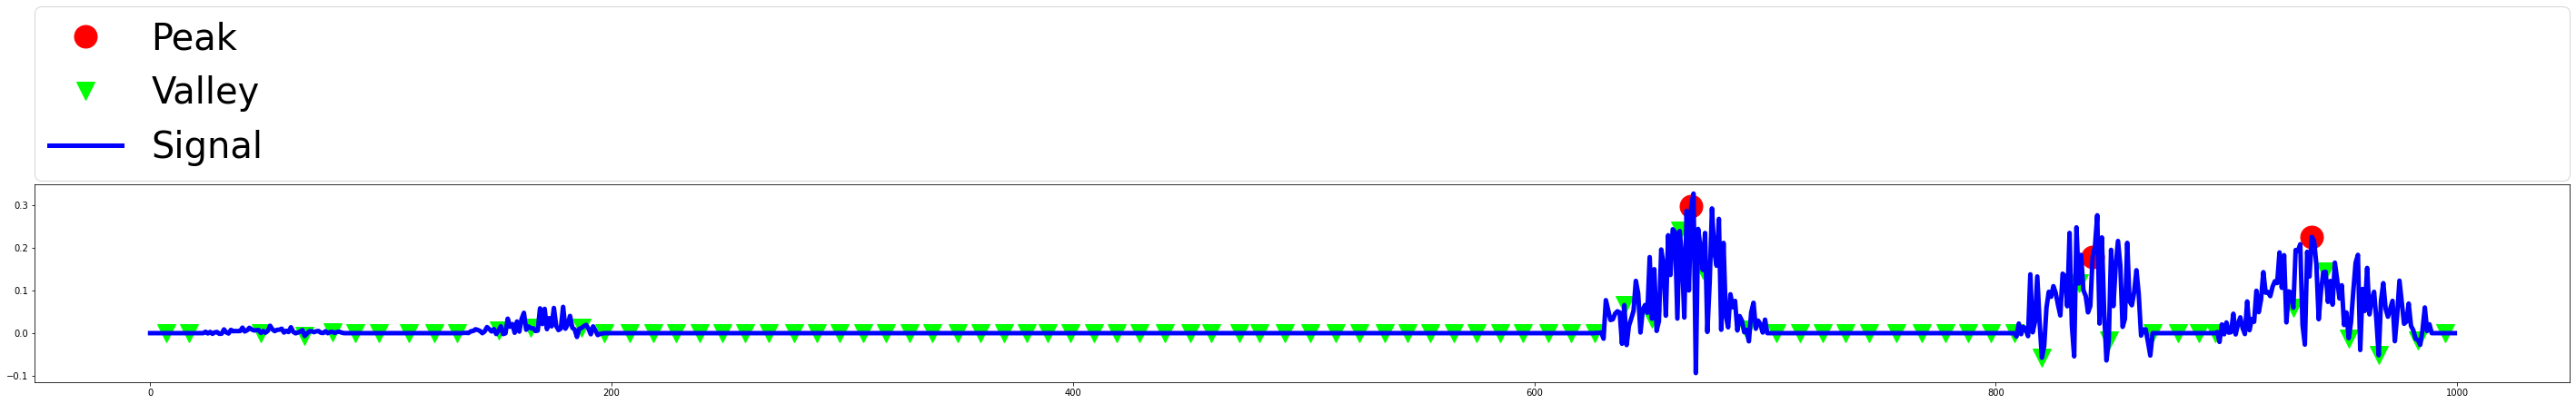

In [14]:
plt.figure(figsize=(50,4))

plt.plot(peaks, sample_signal[peaks], color='red', marker='o',markersize=25, linestyle='None')
plt.plot(valleys, sample_signal[valleys], color='lime', marker='v',markersize=20, linestyle='None')
plt.plot(sample_signal,'blue', linewidth=5)

plt.legend(['Peak','Valley','Signal'],fontsize=40,bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                mode="expand", borderaxespad=0,)

plt.show()

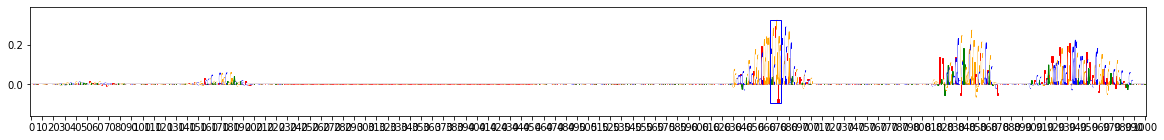

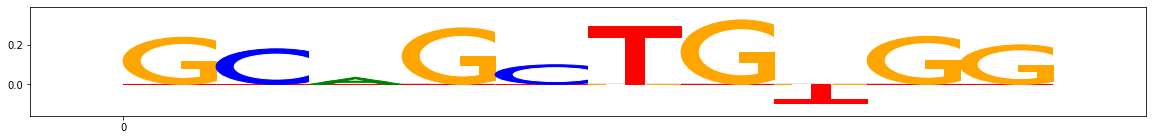

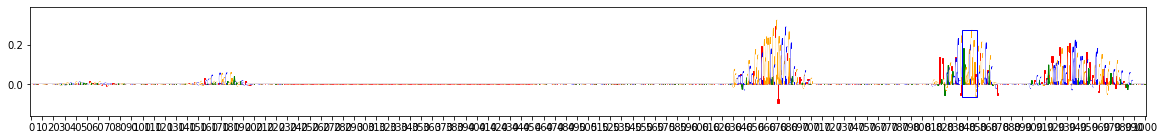

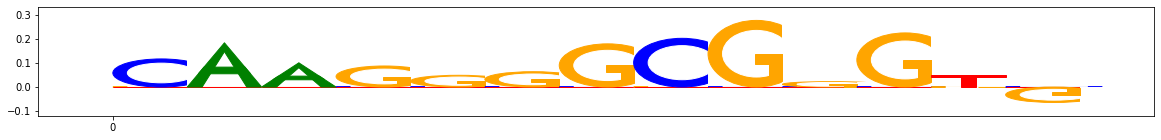

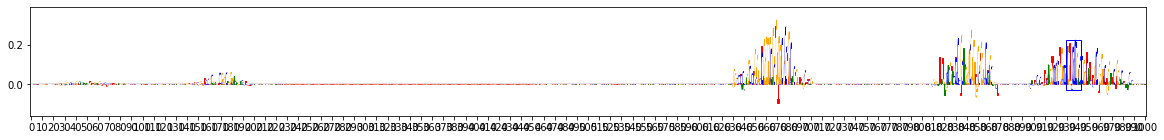

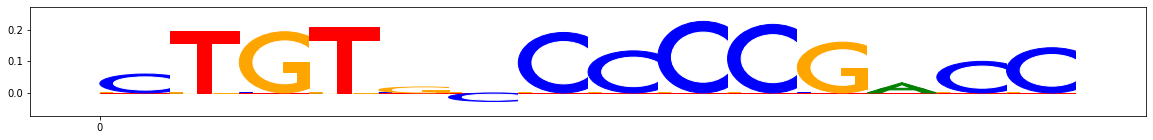

In [15]:
for i in range(3):
    highlight_seq = {'blue': [
                (start_idx[i], end_idx[i])]
            }
    viz_sequence.plot_weights(sample, subticks_frequency=10, highlight=highlight_seq)
    viz_sequence.plot_weights(sample[start_idx[i]:end_idx[i]], subticks_frequency=100)